# Fuzzing with Constraints

In previous chapters, we have seen how [Grammar-Based Fuzzing](GrammarFuzzer.ipynb) allows us to efficiently generate myriads of syntactically valid inputs.
However, there are _semantic_ input features that cannot be expressed in a context-free grammar, such as

* "$X$ is the length of $Y$";
* "$X$ is an identifier previously declared"; or
* "$X$ should be longer than 4,096 bytes".

In this chapter, we show how the *ISLa* framework allows us to express such features as _constraints_ added to a grammar.
By having ISLa solve these constraints automatically, we produce inputs that are not only _syntactically_ valid, but actually _semantically_ valid.
Furthermore, such constraints allow us to very precisely _shape_ the inputs we want for testing.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* You should have read the [chapter on grammars](Grammars.ipynb).
* The chapter on [generators and filters](GeneratorGrammarFuzzer.ipynb) addresses a similar problem, but with program code instead of constraints.

In [2]:
import bookutils

In [3]:
# ignore
import sys

In [4]:
# ignore
if sys.version_info < (3, 10):
    print("This code requires Python 3.10 or later")
    sys.exit(0)

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.FuzzingWithConstraints import <identifier>
```

and then make use of the following features.


This chapter introduces the _ISLa framework_, consisting of 
* the _ISLa specification language_, allowing to add _constraints_ to a grammar
* the _ISLa solver_, solving these constraints to produce semantically (and syntactically) valid inputs
* the _ISLa checker_, checking given inputs for whether they satisfy these constraints.

A typical usage of the ISLa solver is as follows.
First, install ISLa, using 
```shell
$ pip install isla-solver
```
Then, you can import the solver as

```python
>>> from isla.solver import ISLaSolver  # type: ignore
```
The ISLa solver needs two things. First, a _grammar_ - say, US phone numbers.

```python
>>> from Grammars import US_PHONE_GRAMMAR
```
Second, you need )constraints – a string expressing a condition over one or more grammar elements.
Common functions include
* `str.len()`, returning the length of a string
* `str.to.int()`, converting a string to an integer

Here, we instantiate the ISLa solver with a constraint stating that the area code should be above 900:

```python
>>> solver = ISLaSolver(US_PHONE_GRAMMAR, 
>>>             """
>>>             str.to.int(<area>) > 900
>>>             """)
```
With that, invoking `solver.solve()` produces an iterator over multiple solutions.

```python
>>> for _ in range(10):
>>>     print(next(solver.solve()))
(902)465-8279
(910)695-2708
(904)382-9074
(903)632-6458
(914)839-0278
(994)458-0439
(908)847-3098
(901)589-0372
(909)992-6350
(911)431-0475

```
We see that the solver produces a number of inputs that all satisfy the constraint.

The `solve()` method provides several additional parameters to configure the solver, as documented below
Additional `ISLaSolver` methods allow to check inputs against constraints, and provide additional functionality.

```python
/Users/zeller/Projects/fuzzingbook/notebooks/ClassDiagram.ipynb:367: UserWarning: ISLaSolver.solve() is listed as public, but has no docstring
  warnings.warn(f"{f.__qualname__}() is listed as public,"
/Users/zeller/Projects/fuzzingbook/notebooks/ClassDiagram.ipynb:440: UserWarning: Class ISLaSolver has no docstring
  warnings.warn(f"Class {cls.__name__} has no docstring")

```
![](PICS/FuzzingWithConstraints-synopsis-1.svg)

* FIXME: Have docstrings for publicly available methods
* FIXME: Have a docstring for the `ISLaSolver` class
* FIXME: Have a public interface for checking inputs against constraints (preferably in `ISLaSolver`, as it already has the grammar and the constraints).



## Semantic Input Properties

In this book, we have frequently used [grammars](Grammars.ipynb) to [systematically generate inputs](GrammarFuzzer.ipynb) that [cover input structure](GrammarCoverageFuzzer.ipynb) and more.
But while it is relatively easy to express the _syntax_ of an input using a grammar, there are input properties that _cannot_ be expressed using a grammar.
Such input properties are called _semantic_ properties.

Let us illustrate semantic properties using a simple example.
We want to test some system that is configured by two settings, a _page size_ and a _buffer size_. 
Both these come as integer numbers as part of a human-readable configuration file.
The _syntax_ of this file is given by the following grammar:

In [5]:
from Grammars import Grammar, is_valid_grammar, syntax_diagram, crange

In [6]:
import string

In [7]:
CONFIG_GRAMMAR: Grammar = {
    "<start>": ["<config>"],
    "<config>": [
        "pagesize=<pagesize>\n"
        "bufsize=<bufsize>"
    ],
    "<pagesize>": ["<int>"],
    "<bufsize>": ["<int>"],
    "<int>": ["<digit>", "<leaddigit><int>"],
    "<digit>": list("0123456789"),
    "<leaddigit>": list("123456789")
}

In [8]:
assert is_valid_grammar(CONFIG_GRAMMAR)

Here's a visualization of this grammar as a railroad diagram, showing its structure:

start


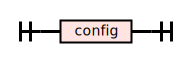

config


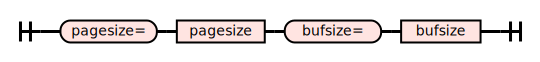

pagesize


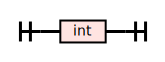

bufsize


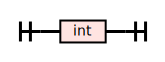

int


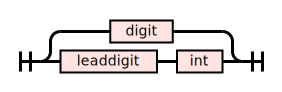

digit


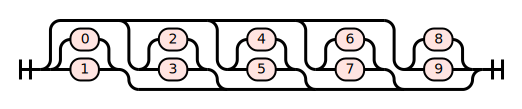

leaddigit


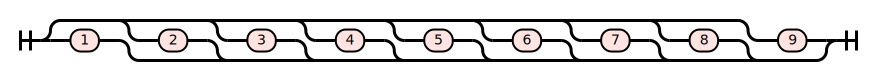

In [9]:
# ignore
syntax_diagram(CONFIG_GRAMMAR)

Using this grammar, we can now use any of our grammar-based fuzzers to generate valid inputs.
For instance:

In [10]:
from GrammarFuzzer import GrammarFuzzer, DerivationTree

In [11]:
fuzzer = GrammarFuzzer(CONFIG_GRAMMAR)

In [12]:
for i in range(10):
    print(i)
    print(fuzzer.fuzz())

0
pagesize=5
bufsize=7
1
pagesize=949
bufsize=1
2
pagesize=3
bufsize=7
3
pagesize=89
bufsize=597
4
pagesize=9
bufsize=0
5
pagesize=35
bufsize=222
6
pagesize=0
bufsize=3
7
pagesize=1
bufsize=58
8
pagesize=351
bufsize=1
9
pagesize=0
bufsize=42


So far, so good - and indeed, these random values will help us test our (hypothetical) system.
But what if we want to _control_ these values further, putting our system to the test?

A grammar gives us _some_ control. If we want to ensure a page size of at least 100,000, for instance, a rule like
```python
"<bufsize>": ["<leaddigit><digit><digit><digit><digit><digit>"]
```
would do the job.
We could also express that the page size should be an odd number, by having it end in an odd digit.
But if we want to state that the page size should be, say, a multiple of 8, or larger or less than the buffer size, we are out of luck.

In the [chapter on fuzzing with generators](GeneratorGrammarFuzzer.ipynb), we have seen how to attach _program code_ to individual rules - program code that would either _generate_ individual elements right away or _filter_ only these that satisfy specific conditions.

Attaching code makes things very flexible, but also has several disadvantages:

* First, it is pretty hard to generate inputs that satisfy multiple constraints at once.
In essence, you have to code your own _strategy_ for generating inputs, which at some point negates the advantage of having an abstract representation such as a grammar.
* Second, your code is not portable. While a grammar can be easily adapted to _any_ grammar-based fuzzer, adding, say, Python code, ties you to the Python environment forever.
* Third, program code can only be used for _producing_ inputs or _checking_ inputs, but not both. This, again, is a downside compared to a pure grammar representation.

Hence, we are looking to a more _general_ way to express semantic properties - and also a more _declarative_ way to express semantic properties.

### Excursion: Unrestricted Grammars

One very general solution to this problem would be to use _unrestricted_ grammars rather than the _context-free_ grammars we have used so far.
In an unrestricted grammar, one can have multiple symbols also on the left hand side of an expansion rule, making them very flexible.
In fact, unrestricted grammars are _Turing-universal_, meaning that they can express any feature that could also be expressed in program code; and they could thus check and produce arbitrary strings with arbitrary features. (If they finish, that is – unrestricted grammars also suffer from the halting problem.)
The downside is that there is literally no programming support for unrestricted grammars – we'd have to implement all of arithmetics, strings, and other functionality from scratch in a grammar, which is - well - not fun.

### End of Excursion

## Specifying Constraints

In recent work, Dominic Steinhöfel and Andreas Zeller (one of the authors of this book) have presented an infrastructure that allows to produce inputs with _arbitrary properties_, but without having to go through the trouble of implementing producers or checkers.
Instead, they suggest a dedicated _language_ for specifiying inputs, named _ISLa_ (for input specification language).
_ISLa_ combines a standard context-free _grammar_ with _constraints_ that express _semantic_ properties of the inputs and their elements.
ISLa can be used as a _fuzzer_ (producing inputs that satisfy the constraints) as well as a _checker_ (checking inputs whether they satisfy the given constraints).

Let us illustrate ISLa by example. ISLa comes as a Python package named `isla-solver` that can be easily installed using `pip`:

```shell
$ pip install isla-solver
```

This also installs all dependent packages (such as `fuzzingbook`, for instance).

The core of ISLa is the _ISLa Solver_ – the component that actually _solves_ constraints to produce satisfying inputs.

In [13]:
import isla  # type: ignore

In [14]:
from isla.solver import ISLaSolver  # type: ignore

The constructor of an `ISLASolver` takes two mandatory arguments.
* The _grammar_ is the grammar the solver should produce inputs from.
* The _constraint_ is the constraint the produced inputs should satisfy.

To express a constraint, we have a variety of _functions_ and _predicates_ at our disposition.
These can be applied to individual elements of the grammar, notably their nonterminals.
The function `str.len()`, for instance, returns the length of a string.
If we want to have inputs in which the page size has at least 6 digits, we can write:

In [15]:
solver = ISLaSolver(CONFIG_GRAMMAR, 'str.len(<pagesize>) >= 6')

The method `solve()` returns an iterator over all produced strings from the ISLa solver. To get these inputs, we can thus write

In [16]:
for i in range(10):
    print(i)
    print(next(solver.solve()))   

0
pagesize=822280
bufsize=2
1
pagesize=448880
bufsize=99
2
pagesize=888420
bufsize=4
3
pagesize=822210
bufsize=6
4
pagesize=824480
bufsize=2
5
pagesize=842420
bufsize=90
6
pagesize=888210
bufsize=1
7
pagesize=842210
bufsize=81
8
pagesize=822480
bufsize=4
9
pagesize=848410
bufsize=5


... and we see that, indeed, each page size has exactly six digits.

To express a minimum numeric value, however, we can use a more elegant way.
The function `str.to_int()`, for instance, converts a string into an integer.
To obtain a page size that of at least 100000, we can thus also write

In [17]:
solver = ISLaSolver(CONFIG_GRAMMAR,
                    'str.to.int(<pagesize>) >= 100000')
print(next(solver.solve()))

pagesize=1921440
bufsize=10


If we want the page size to be in the range of 100 to 200, we can state this as a logical conjunction (using `and`)

In [18]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                    '''
                    str.to.int(<pagesize>) >= 100 and 
                    str.to.int(<pagesize>) <= 200
                    ''')
print(next(solver.solve()))

pagesize=110
bufsize=31


And if we want the page size to be a multiple of seven, we can write

In [19]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                    '''
                    (= (mod (str.to.int <pagesize>) 7) 0)
                    ''')
print(next(solver.solve()))

Evaluation of expression StrToInt("0")%7 not implemented.
Evaluation of expression StrToInt("7")%7 not implemented.
Evaluation of expression StrToInt("70")%7 not implemented.
Evaluation of expression StrToInt("14")%7 not implemented.
Evaluation of expression StrToInt("28")%7 not implemented.
Evaluation of expression StrToInt("35")%7 not implemented.
Evaluation of expression StrToInt("77")%7 not implemented.
Evaluation of expression StrToInt("56")%7 not implemented.
Evaluation of expression StrToInt("84")%7 not implemented.
Evaluation of expression StrToInt("21")%7 not implemented.


pagesize=0
bufsize=0


* FIXME: How do I write this in infix syntax?
* FIXME: Suppress warnings unless relevant for the user

In [20]:
from bookutils import quiz

In [21]:
quiz("Which of the following constraints expresses "
     "that the page size and the buffer size "
     "have to be equal? Try it out!",
     [
         "`<pagesize> is <bufsize>`",
         "`str.to.int(<pagesize>) = str.to.int(<bufsize>)`",
         "`<pagesize>) = <bufsize>`",
         "`atoi(<pagesize>) == atoi(<bufsize>)`",
     ], "[4 ** 0.5, 9 ** 0.5]")

Indeed, ISLa constraints can also involve multiple elements. Expressing equality between two elements is easy, and uses a single equal siqn. (There's no assignment in ISLa the `=` could be confused with.)

In [22]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                    '''
                    <pagesize> = <bufsize>
                    ''')
print(next(solver.solve()))

pagesize=8
bufsize=8


We can also use numerical constraints, stating that the buffer size should always be exactly one more than the page size:

In [23]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                    '''
                    str.to.int(<pagesize>) > 1024 and
                    str.to.int(<bufsize>) = str.to.int(<pagesize>) + 1
                    ''')
print(next(solver.solve()))

pagesize=1790
bufsize=1791


All the above functions (like `str.to.int()`) actually stem from the _SMT-LIB_ library for _satisfiability modulo theories_ (SMT), a standard for expressing constraints for constraint solvers (like ISLa).
The [list of all theories defined in SMT-LIB](https://smtlib.cs.uiowa.edu/theories.shtml) lists dozens of functions and predicates that can be used in ISLa constraints.

In [24]:
quiz("Which constraints are necessary to "
     "ensure that all digits are between 1 and 3?",
     [
         "`str.to.int(<digit>) >= 1`",
         "`str.to.int(<digit>) <= 3`",
         "`str.to.int(<leaddigit>) >= 1`",
         "`str.to.int(<leaddigit>) <= 3`",
     ], "[1 ** 0, 4 ** 0.5, 16 ** 0.5]")

### Excursion: Using SMT-LIB Syntax

Instead of the above "infix" syntax which is familiar to programmers, ISLa also supports full SMT-LIB syntax.
Instead of writing $f(x_1, x_2, x_3, \dots)$ for a function $f$ and its arguments $x_1 \dots x_n$, SMT-LIB uses a "prefix" LISP-like syntax in which all functions and operators are written as $(f x_1 x_2 x_3 \dots)$.
The above predicate would thus be written as

In [25]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                '''
                (> (str.to.int <pagesize>) 1024)
                and
                (= (str.to.int <bufsize>) (+ (str.to.int <pagesize>) 1))
                ''')
print(next(solver.solve()))

pagesize=5480
bufsize=5481


Note that for boolean operators such as `and`, we still use the ISLa infix syntax; having ISLa handle these operators is more efficient than passing them on to the constraint solver.

* FIXME: Support `and` as part of SMT-LIB expressions

### End of Excursion

## Accessing Elements

So far, we have accessed nonterminals simply by referencing their name, as in `<bufsize>` or `<pagesize>`.
However, in some cases, this simple method is not sufficient.
In our configuration grammar, for instance, we may want to access (or constrain) `<int>` elements.
However, we do not want to constrain _all_ integers at once, but only those in a particular _context_ – say, those that occur as a part of a `<pagesize>` element, or only those that occur as part of a `<config>` element.

To this end, ISLa allows to reference _parts_ of a given element, using two special operators.

The expression `<a>.<b>` refers to the _immediate_ subpart `<b>` of some element `<a>`.
That is, `<b>` has to appear in one of the expansion rules of `<a>`.
For instance, `<pagesize>.<int>` refers to the `<int>` element of a page size.
Here is an example using the dot operator:

In [26]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                '''
                <pagesize>.<int> = <bufsize>.<int>
                ''')
print(next(solver.solve()))

pagesize=0
bufsize=0


The expression `<a>..<b>`, however, refers to _any_ subpart `<b>` of some element `<a>`. That is, `<b>` can appear in the expansion of `<a>`, but also in the expansion of any subelement (and any subelement thereof).
Here is an example using the double dot operator, enforcing _every_ digit in a `<config>` element to be `7`:

In [27]:
from ExpectError import ExpectError

In [28]:
with ExpectError():
    solver = ISLaSolver(CONFIG_GRAMMAR, 
                '''
                <config>..<digit> = "7"
                ''')
    print(next(solver.solve()))

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_76620/2177507368.py", line 2, in <module>
    solver = ISLaSolver(CONFIG_GRAMMAR,
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/solver.py", line 236, in __init__
    formula = parse_isla(formula, grammar, structural_predicates, semantic_predicates)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/language.py", line 2693, in parse_isla
    antlr4.ParseTreeWalker().walk(isla_emitter, parser.start())
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/antlr4/tree/Tree.py", line 161, in walk
    self.exitRule(listener, t)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/antlr4/tree/Tree.py", line 188, in exitRule
    ctx.exitRule(listener)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/isla_language/IslaLanguageParser.py", line 202, in exitRule
    l

To reason about dots and double dots, it helps visualizing the string in question as a _derivation tree_ discussed in the [chapter on grammar-based fuzzing](GrammarFuzzer.ipynb).
The derivation tree of the input 
```
pagesize=12
bufsize=34
```
for instance, looks like this:

In [29]:
# ignore
from Parser import EarleyParser  # minor dependency
from GrammarFuzzer import display_tree

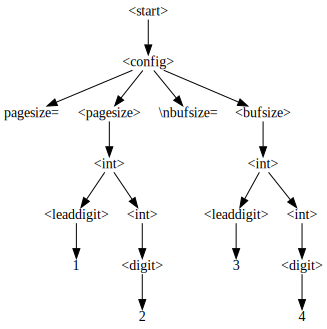

In [30]:
# ignore
inp = 'pagesize=12\nbufsize=34'
parser = EarleyParser(CONFIG_GRAMMAR)
tree = next(parser.parse(inp))
display_tree(tree)

In this tree, the `.` syntax refers to _immediate_ children. `<bufsize>.<int>` is the one `<int>` node that is the immediate descendant of `<bufsize>` (but not any other `<int>` node).
In contrast, `<config>..<digit>` refers to _all_ `<digit>` descendants of the `<config>` node.

If an element has multiple children of the same type, one can use the special `<a>[$n$]` syntax to access the $n$-th child of type `<a>`. (Note that to access the first child, $n$ is equal to one, not zero.) If, for whatever reason, we wanted to ensure that the second `<digit>` in our `<int>` elements is 7, we can enforce this with

In [31]:
with ExpectError():
    solver = ISLaSolver(CONFIG_GRAMMAR, 
                '''
                <int>.<digit>[2] = "7"
                ''')
    print(next(solver.solve()))

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_76620/3992921923.py", line 2, in <module>
    solver = ISLaSolver(CONFIG_GRAMMAR,
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/solver.py", line 236, in __init__
    formula = parse_isla(formula, grammar, structural_predicates, semantic_predicates)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/language.py", line 2693, in parse_isla
    antlr4.ParseTreeWalker().walk(isla_emitter, parser.start())
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/antlr4/tree/Tree.py", line 160, in walk
    self.walk(listener, child)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/antlr4/tree/Tree.py", line 160, in walk
    self.walk(listener, child)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/antlr4/tree/Tree.py", line 160, in walk
    self.walk(listener, child)

Note that `<digit>[2]` is actually the _third_ digit in our integers; the first digit is the `<leaddigit>`, followed by `<digit>[1]`, and then `<digit>[2]`.

* FIXME: Is there more support for XPath-like selectors? If so, we should have an excursion for them
* FIXME: Does ISLa really start counting with 1?

## Quantifiers

By default, all nonterminals in ISLa constraints are _universally_ quantified - that is, any constraint applying to, say, some `<int>` element applies to _all_ `<int>` elements in the resulting string.
If you only want to constrain _one_ element, though, you have to (and can) specify this in ISLa, using an _existential quantifier_.

To use an existential quantifier in ISLa, use the construct
```
exists TYPE VARIABLE in CONTEXT:
    (CONSTRAINT)
```
where `VARIABLE` is some identifier, `TYPE` is its type (as a nonterminal), and `CONTEXT` is the context (again a nonterminal) in which the constraint should hold.
`CONSTRAINT` is again a constraint expression, in which you now can make use of `VARIABLE` as the element whose existence you assume.

Let us illustrate existential quantification again using a simple example.
We want to make sure that at least one integer in our generated string has a value of more than 1000.
So we write

In [32]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
            '''
            exists <int> i in <start>:
                (str.to.int(i) > 1000)
            ''')
for i in range(10):
    print(i)
    print(next(solver.solve()))

0
pagesize=14
bufsize=1110
1
pagesize=5
bufsize=1154
2
pagesize=54
bufsize=7154
3
pagesize=7
bufsize=8920
4
pagesize=1
bufsize=8220
5
pagesize=66
bufsize=1220
6
pagesize=9
bufsize=1940
7
pagesize=9
bufsize=5920
8
pagesize=1
bufsize=2220
9
pagesize=95
bufsize=8420


We note that all generated inputs satisfy the constraint of having at least one integer that satisfies the constraint.

Besides existential quantification, there also is _universal_ quantification, using the `forall` keyword instead of `exists`.
If we want _all_ elements in some context to satisfy a constraint, this comes in handy.

In [33]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
            '''
            forall <int> i in <start>:
                (str.to.int(i) > 1000)
            ''')
print(next(solver.solve()))

pagesize=1130
bufsize=8150


We see that all `<int>` elements satisfy the constraint.

* FIXME: Is it `<start>` or `start`? (IMHO, only the former should be allowed.)

By default, all nonterminals that re used directly in constraints are universally quantified within the `<start>` symbol, so the above can actually be simplified to

In [34]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
            '''
            str.to.int(<int>) > 1000
            ''')
print(next(solver.solve()))

pagesize=2930
bufsize=2180


... and you realize that in all our initial constraints, we always had an implicit universal quantification.

* FIXME: The above `forall` iterators return only one solution. Why?

## Picking Expansions

Sometimes, we'd like a quantifier to apply only for a specific expansion alternative of a nonterminal.
The form
```
forall TYPE VARIABLE=PATTERN in CONTEXT:
    (CONSTRAINT)
```
means that the CONSTRAINT only applies to a VARIABLE that actually matches the expansion given in PATTERN.
(Again, we can replace `forall` with `exists`, and make this an existential quantification rather than a universal quantification.)

In our grammar, we have two possible expansions for `<int>`, namely `<digit>` (for values 0..9) and `<leaddigit><int>` (for 10 and above):
```
<int> ::= <digit> | <leaddigit><int>
```

If we now want to constrain only _one_ of the two alternatives, we can use the following expression:

In [35]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
            '''
            forall <int> i="<digit>" in <start>:
                (i = "7")
            ''')

This ensures that _if_ `<int>` is expanded to a single digit, this single digit becomes `7`.
The effect is that all `<int>` values now end in a `7` digit:

In [36]:
print(next(solver.solve()))

pagesize=37
bufsize=7


Likewise, we can constrain `i` to the second expansion alternative, and thus ensure that all multi-digit numbers are greater than 100:

In [37]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
            '''
            forall <int> i="<leaddigit><int>" in <start>:
                (str.to.int(i) > 100)
            ''')

Here, however, the solver can also choose the less constrained alternative for `<int>`s, picking single digits:

In [38]:
print(next(solver.solve()))

pagesize=5
bufsize=6


## Matching Expansion Elements

In a quantification pattern, we can also _name_ individual nonterminal elements and use them in our constraints.
This is done by replacing the nonterminal `<ID>` with the special form `{<ID> VARIABLE}` (in curly braces) which then makes the variable VARIABLE a placeholder for the value matched by ID; VARIABLE can then be used in constraints.

Here is an example. In the expansion `<leaddigit><int>`, we want to ensure that the `<leaddigit>` is always `9`.
Using the special brace form, we make `lead` a variable holding the value of `<leaddigit>`, and can then use it in a constraint:

In [39]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
            '''
            forall <int> i="{<leaddigit> lead}{<int> remainder}" in <start>:
                (lead = "9")
            ''')

This (again) ensures that all lead digits should be `9`:

In [40]:
print(next(solver.solve()))

pagesize=2
bufsize=7


... if we _have_ <leaddigit> elements, that is.
    Fortunately, ISLa is set up to systematically cover all alternatives.
Hence, the next solution actually _does_ contain a `<leaddigit>` element, and it is properly constrained.

In [41]:
for i in range(1, 10):
    print(i)
    print(next(solver.solve()))

1
pagesize=5
bufsize=92
2
pagesize=94
bufsize=7
3
pagesize=91
bufsize=98
4
pagesize=98
bufsize=995
5
pagesize=4
bufsize=995
6
pagesize=996
bufsize=97
7
pagesize=997
bufsize=6
8
pagesize=9999
bufsize=1
9
pagesize=9992
bufsize=96


(Note how ISLa systematically explores longer and longer combinations of lead digits here – this again is due to ISLa exploring all possible syntactic combinations.)

Could we express the above in a simpler fashion? Of course! Using implicit universal quantification and the dot notation introduced earlier, we could write, for instance

In [42]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
            '''
            <int>.<leaddigit> = "9"
            ''')

and obtain the same result:

In [43]:
for i in range(10):
    print(i)
    print(next(solver.solve()))

0
pagesize=4
bufsize=6
1
pagesize=94
bufsize=5
2
pagesize=2
bufsize=91
3
pagesize=95
bufsize=91
4
pagesize=995
bufsize=90
5
pagesize=6
bufsize=991
6
pagesize=993
bufsize=8
7
pagesize=95
bufsize=991
8
pagesize=9992
bufsize=95
9
pagesize=0
bufsize=9994


But while the dot notation is sufficient for many cases, the pattern matching notation is more general and more flexible – even if it is harder to read.

## Checking Inputs

Using an `ISLaSolver`, we can also check if an input satisfies the constraints.
Let us check if in a given input, `<pagesize>` and `<bufsize>` are the same.

In [44]:
constraint = '<pagesize> = <bufsize>'
solver = ISLaSolver(CONFIG_GRAMMAR, constraint)

First, we need to parse the input into a derivation tree. This is done using the `parse()` method.
Note that this does not yet check the constraint; it will, however, detect if the given string does not conform to the grammar.

In [45]:
tree = solver.parse('<config>', 'pagesize=12\nbufsize=34')

* FIXME: The `nonterminal` should be an optional second parameter, and default to `<start>`
* FIXME: Using `<start>` as `nonterminal` always fails

To check the tree, we can pass it into the `evaluate()` function – and find that the given input does _not_ satisfy our constraint.

In [46]:
from isla.evaluator import evaluate  # type: ignore

In [47]:
evaluate(constraint, tree, CONFIG_GRAMMAR)

ThreeValuedTruth(0)

If we repeat the above, however, with an input that satisfies the constraint, we obtain a `true` result.

In [48]:
tree = solver.parse('<config>', 'pagesize=27\nbufsize=27')

In [49]:
evaluate(constraint, tree, CONFIG_GRAMMAR)

ThreeValuedTruth(1)

* FIXME: `evaluate()` should become part of the solver (which already has the constraints and the grammar); optionally also include the parsing step
* FIXME: `'pagesize=1027\nbufsize=1027'` does not parse

## Case Studies

Let us further illustrate ISLa using a few case studies.

### Matching Identifiers in XML

The Extensible Markup Language (XML) is a typical example of an input language that cannot be fully expressed using a context-free grammar.
The problem is not so much expressing the _syntax_ of XML – the basics are fairly easy:

In [50]:
XML_GRAMMAR: Grammar = {
    "<start>": ["<xml-tree>"],
    "<xml-tree>": ["<open-tag><xml-content><close-tag>"],
    "<open-tag>": ["<<id>>"],
    "<close-tag>": ["</<id>>"],
    "<xml-content>": ["Text", "<xml-tree>"],
    "<id>": ["<letter>", "<id><letter>"],
    "<letter>": crange('a', 'z')
}

In [51]:
assert is_valid_grammar(XML_GRAMMAR)

start


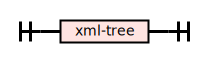

xml-tree


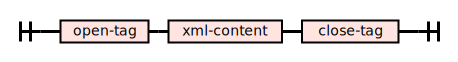

open-tag


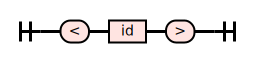

close-tag


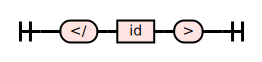

xml-content


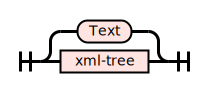

id


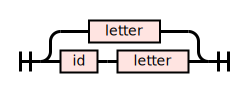

letter


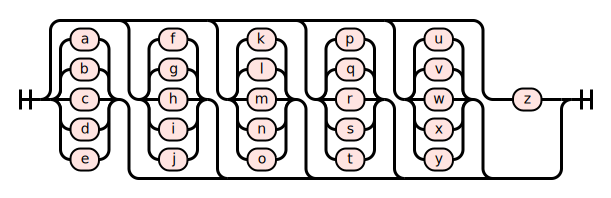

In [52]:
# ignore
syntax_diagram(XML_GRAMMAR)

The problem becomes evident when we produce inputs from the grammar: The `<id>` elements in `<open-tag>` and `<close-tag>` do not match.

In [53]:
fuzzer = GrammarFuzzer(XML_GRAMMAR)
fuzzer.fuzz()

'<rfi><d><u><sfrbw><m><ku>Text</ugp></ym></im></hp></s></h>'

If we want the tag IDs to match, we need to come up with a _finite_ set of tags (as in, say, HTML); then we can extend the grammar with one rule for each tag - `<body>...</body>`, `<p>...</p>`, `<strong>...</strong>`, and so on.
For an _infinite_ set of tags, though, as in our grammar, expressing that the two tag IDs must match is not possible in a context-free grammar.

With ISLa, however, constraining the grammar is easy.
All we need is the rule that constrains the `<xml-tree>`:

In [54]:
solver = ISLaSolver(XML_GRAMMAR, 
            '''
            <xml-tree>.<open-tag>.<id> = <xml-tree>.<close-tag>.<id>
            ''')
for _ in range(3):
    print(next(solver.solve()))

<p>Text</p>
<p><p>Text</p></p>
<p><p><p>Text</p></p></p>


and we see that the `<id>` tags now indeed match each other.

* FIXME: This is rather slow. If we have simple equality A = B, one may also go and generate A and then set B to the value of A (or vice versa)

In contrast to the "input generator" solution in the [chapter on generators](GeneratorGrammarFuzzer), our constraint-based solution is purely declarative - and can also be used to parse and check inputs.
Plus, of course, we can easily add more constraints:

In [55]:
solver = ISLaSolver(XML_GRAMMAR, 
            '''
            <xml-tree>.<open-tag>.<id> = <xml-tree>.<close-tag>.<id>
            and
            str.len(<id>) > 10
            ''')
for _ in range(3):
    print(next(solver.solve()))

<ppkpscplahk>Text</ppkpscplahk>
<ppmpuilmcdp><ppmpuilmcdp>Text</ppmpuilmcdp></ppmpuilmcdp>
<ppnpsklkaln><ppnpsklkaln><ppnpsklkaln>Text</ppnpsklkaln></ppnpsklkaln></ppnpsklkaln>


### Definitions and Usages in Programming Languages

When testing compilers with generated program code, one often encounters the problem that before _using_ an identifier, one has to _declare_ it first - specifying its type, some initial value, and more.

This problem is easily illustrated in the following grammar, which produces _sequences of assignments_.
Variable names consist of a single lowercase letter; values can only be digits; assignments are separated by semicolons.

In [56]:
LANG_GRAMMAR: Grammar = {
    "<start>":
        ["<stmt>"],
    "<stmt>":
        ["<assgn>", "<assgn>; <stmt>"],
    "<assgn>":
        ["<lhs> := <rhs>"],
    "<lhs>":
        ["<var>"],
    "<rhs>":
        ["<var>", "<digit>"],
    "<var>": list(string.ascii_lowercase),
    "<digit>": list(string.digits)
}

In [57]:
assert is_valid_grammar(LANG_GRAMMAR)

start


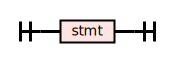

stmt


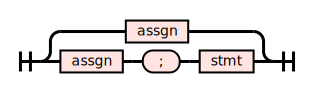

assgn


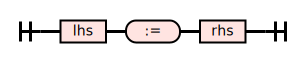

lhs


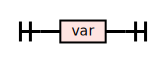

rhs


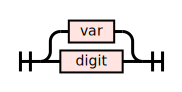

var


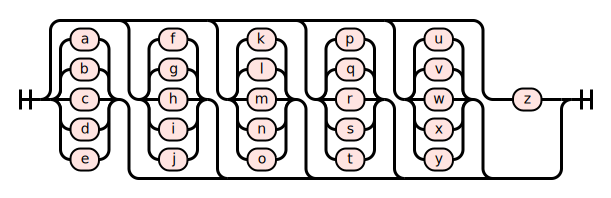

digit


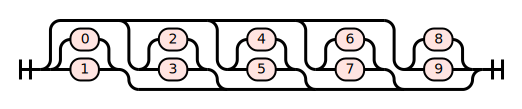

In [58]:
syntax_diagram(LANG_GRAMMAR)

Here are some assignment sequences produced by the grammar:

In [59]:
fuzzer = GrammarFuzzer(LANG_GRAMMAR)

In [60]:
for _ in range(10):
    print(fuzzer.fuzz())

h := v
e := k
t := i; v := 5
e := 2
j := b; y := 7
j := g; n := 5; k := 5
k := g; c := n; x := 4; b := 9; k := c
i := 1; y := 8; s := w; t := 7; d := 0
k := f
p := 5; e := 1


We see that the assignment _syntax_ is similar to what we have in common programming languages.
The _semantics_, however, are, well, questionable, as we commonly access variables whose values have not been previously defined.
Again, this is a _semantic_ property that cannot be expressed in a context-free grammar alone.

What we need here is a constraint specifying that on the right-hand side of an assignment, we can only have variable names that occur on the left-hand side.
In ISLa, we achive this thorugh the following constraint:

In [61]:
solver = ISLaSolver(LANG_GRAMMAR, 
            '''
            forall <rhs> in <stmt>:
                exists <lhs> in <stmt>:
                    <rhs>.<var> = <lhs>.<var>
            ''')

In [62]:
for _ in range(10):
    print(next(solver.solve()))

p := 5
p := 9; r := 3
j := 5; r := j
p := 7; r := p
d := 5; v := d
x := 1; j := x
b := 7; x := b
h := 3; z := h
a := 8; v := a
c := 6; p := c


This is much better already, but not perfect yet - we might still have assignments like `a := a` or `a := b; b := 5`.
That is because our constraints do not yet take care of _ordering_ – in a `<rhs>` element, we can only use variables that are defined earlier.

For this purpose, ISLa provides a `before()` predicate: `before(A, B)` expresses that the element `A` must occur before the element `B`.
With `before()`, we can rewrite our constraint as

In [63]:
solver = ISLaSolver(LANG_GRAMMAR, 
            '''
            forall <rhs> in <stmt>:
                exists <lhs> in <stmt>:
                    (before(<lhs>, <rhs>) and
                     <rhs>.<var> = <lhs>.<var>)
            ''')

... and thus ensure that on the right-hand-side of assignments, we only use identifiers defined earlier.

In [64]:
for _ in range(10):
    print(next(solver.solve()))

p := 5
v := 6; e := 8
h := 9; m := h
v := 9; d := v
f := 5; e := f
p := 6; u := p
t := 4; o := t
b := 0; f := b
u := 6; n := u
d := 7; x := d


* FIXME: What does one have to do to prevent `a := a`, though?

In case you find that the assignment sequences are too short, you can use the ISLa `count()` predicate.
`count(VARIABLE, NONTERMINAL, N)` ensures that the number of NONTERMINALs in VARIABLE is exactly N.
To have statements with exactly 5 assignments, write

In [65]:
solver = ISLaSolver(LANG_GRAMMAR, 
            '''
            forall <rhs> in <stmt>:
                exists <lhs> in <stmt>:
                    (before(<lhs>, <rhs>) and
                     <rhs>.<var> = <lhs>.<var>)
            and
            count(<start>, "<assgn>", 5)
            ''')

In [66]:
with ExpectError():
    for _ in range(10):
        print(next(solver.solve()))

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_76620/2187918683.py", line 3, in <module>
    print(next(solver.solve()))
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/solver.py", line 376, in solve
    result_state = self.eliminate_all_ready_semantic_predicate_formulas(state)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/solver.py", line 776, in eliminate_all_ready_semantic_predicate_formulas
    evaluation_result = semantic_predicate_formula.evaluate(self.graph, negate=negated)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/language.py", line 854, in evaluate
    return self.predicate.evaluate(graph, *self.args, negate=negate)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/language.py", line 831, in evaluate
    return self.eval_fun(graph, *instantiations)
  File "/Users/zeller/.pyenv/versions/3.10.2/li

* FIXME: What am I doing wrong here?

Here's a poor man's alternative:

In [67]:
solver = ISLaSolver(LANG_GRAMMAR, 
            '''
            str.len(<stmt>) > 20
            ''')

In [68]:
with ExpectError():
    for _ in range(10):
        print(next(solver.solve()))

p := 2; p := 2; p := 0


Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_76620/2187918683.py", line 3, in <module>
    print(next(solver.solve()))
StopIteration (expected)


* FIXME: This doesn't satisfy the constraint either :-(

## Synopsis

This chapter introduces the _ISLa framework_, consisting of 
* the _ISLa specification language_, allowing to add _constraints_ to a grammar
* the _ISLa solver_, solving these constraints to produce semantically (and syntactically) valid inputs
* the _ISLa checker_, checking given inputs for whether they satisfy these constraints.

A typical usage of the ISLa solver is as follows.
First, install ISLa, using 
```shell
$ pip install isla-solver
```
Then, you can import the solver as

In [69]:
from isla.solver import ISLaSolver  # type: ignore

The ISLa solver needs two things. First, a _grammar_ - say, US phone numbers.

In [70]:
from Grammars import US_PHONE_GRAMMAR

Second, you need )constraints – a string expressing a condition over one or more grammar elements.
Common functions include
* `str.len()`, returning the length of a string
* `str.to.int()`, converting a string to an integer

Here, we instantiate the ISLa solver with a constraint stating that the area code should be above 900:

In [71]:
solver = ISLaSolver(US_PHONE_GRAMMAR, 
            """
            str.to.int(<area>) > 900
            """)

With that, invoking `solver.solve()` produces an iterator over multiple solutions.

In [72]:
for _ in range(10):
    print(next(solver.solve()))

(902)465-8279
(910)695-2708
(904)382-9074
(903)632-6458
(914)839-0278
(994)458-0439
(908)847-3098
(901)589-0372
(909)992-6350
(911)431-0475


We see that the solver produces a number of inputs that all satisfy the constraint.

The `solve()` method provides several additional parameters to configure the solver, as documented below
Additional `ISLaSolver` methods allow to check inputs against constraints, and provide additional functionality.

In [73]:
# ignore
import warnings

/Users/zeller/Projects/fuzzingbook/notebooks/ClassDiagram.ipynb:367: UserWarning: ISLaSolver.solve() is listed as public, but has no docstring
  warnings.warn(f"{f.__qualname__}() is listed as public,"
/Users/zeller/Projects/fuzzingbook/notebooks/ClassDiagram.ipynb:440: UserWarning: Class ISLaSolver has no docstring
  warnings.warn(f"Class {cls.__name__} has no docstring")


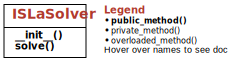

In [74]:
# ignore
with warnings.catch_warnings():
    warnings.simplefilter("default")

    from ClassDiagram import display_class_hierarchy
    hierarchy = display_class_hierarchy([ISLaSolver],
                           public_methods=[
                                ISLaSolver.__init__,
                                ISLaSolver.solve,
                            ])
hierarchy

* FIXME: Have docstrings for publicly available methods
* FIXME: Have a docstring for the `ISLaSolver` class
* FIXME: Have a public interface for checking inputs against constraints (preferably in `ISLaSolver`, as it already has the grammar and the constraints).

## Lessons Learned

* Using ISLa, we can add and solve _constraints_ to grammars, allowing to express _semantic properties_ of our test inputs
* Declaring constraints (and have a solver solve them) is much more versatile than adding generator code, and language-independent, too
* Using ISLa is fun :-)

## Next Steps

In the next chapters, we will continue to focus on semantics.
Among others, we will learn how to

* [mine grammars from existing inputs](GrammarMiner.ipynb)
* use [symbolic fuzzing](SymbolicFuzzer.ipynb) - that is, using constraint solvers to reach particular locations
* use [concolic fuzzing](ConcolicFuzzer.ipynb) - that is, combining symbolic fuzzing with concrete runs for higher efficiency

## Background

* ISLa is presented in the paper ["Input Invariants"](https://publications.cispa.saarland/3596/) at ESEC/FSE 2022.
* The [ISLa project](https://github.com/rindPHI/isla) contains the full source code and a complete reference.

## Exercises

### Exercise 1: String Encodings

A common way of representing strings is _length-prefixed strings_, a representation made popular by the Pascal programming language.
A length-prefixed string starts with a few bytes that encode the length $L$ of the string, followed by the $L$ actual characters.
For instance, assuming that two bytes are used to encode the length, the string `"Hello"` could be represented as the sequence

```
0x00 0x05 'H' 'e' 'l' 'l' 'o'
```

#### Part 1: Syntax

Write a grammar that defines the syntax of length-prefixed strings.

**Solution.** This is actually pretty easy:

In [75]:
import string

In [76]:
PASCAL_STRING_GRAMMAR: Grammar = {
    "<start>": ["<string>"],
    "<string>": ["<length><chars>"],
    "<length>": ["<high-byte><low-byte>"],
    "<high-byte>": ["<byte>"],
    "<low-byte>": ["<byte>"],
    "<byte>": crange('\x00', '\xff'),
    "<chars>": ["", "<char><chars>"],
    "<char>": list(string.printable),
}

In [77]:
assert is_valid_grammar(PASCAL_STRING_GRAMMAR)

In [78]:
fuzzer = GrammarFuzzer(PASCAL_STRING_GRAMMAR)

In [79]:
for _ in range(10):
    print(repr(fuzzer.fuzz()))

'Ù¹\n'
'ôÃ'
'\x02h-'
'Í\x8f'
'\x95x'
'\x9dmB'
"'5"
'¥»9'
'µW'
'´\x80'


#### Part 2: Semantics

Use ISLa to produce valid length-prefixed strings.
Make use of the [SMT-LIB string library](https://smtlib.cs.uiowa.edu/theories-UnicodeStrings.shtml) to find appropriate conversion functions.

**Solution.** 
The function we need is `str.to_code(c)` to convert a single character to its ordinal value (e.g. `str.to_code('0x03') = 3`).
With this, we can formulate an appropriate constraint:

In [80]:
solver = ISLaSolver(PASCAL_STRING_GRAMMAR, 
            '''
            str.to_code(<low-byte>) +
            str.to_code(<high-byte>) * 256 =
            str.len(<chars>)
            ''')

In [81]:
with ExpectError():
    for _ in range(10):
        print(next(solver.solve()))

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_76620/2187918683.py", line 3, in <module>
    print(next(solver.solve()))
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/solver.py", line 370, in solve
    result_states = self.eliminate_all_semantic_formulas(state)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/solver.py", line 741, in eliminate_all_semantic_formulas
    return self.eliminate_semantic_formula(
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/solver.py", line 1192, in eliminate_semantic_formula
    all_solutions: List[List[Dict[Union[language.Constant, DerivationTree], DerivationTree]]] = [
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/solver.py", line 1193, in <listcomp>
    self.solve_quantifier_free_formula(cluster) for cluster in formula_clusters
  File "/Users/zeller/.pyenv/versions/3.10.2

* FIXME: What's going on here?